# Import Libraries

In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import mean_absolute_error, mean_squared_error

# H1 Timeframe

In [2]:
# read in 2019 full year 1 hour timeframe price data
df_h1 = pd.read_csv('../data/df_h1.csv', index_col='date')
df_h1.index = pd.to_datetime(df_h1.index)
df_h1 = df_h1.dropna()
df_h1.head()

,open,high,low,close
date,,,,
2003-01-01 19:00:00,1.0504,1.0504,1.0476,1.0485
2003-01-01 20:00:00,1.0487,1.0498,1.0485,1.0487
2003-01-01 21:00:00,1.0488,1.0489,1.0477,1.0477
2003-01-01 22:00:00,1.0478,1.0483,1.0468,1.0470
2003-01-01 23:00:00,1.0469,1.0477,1.0469,1.0476


In [3]:
df_h1.shape

(105631, 4)

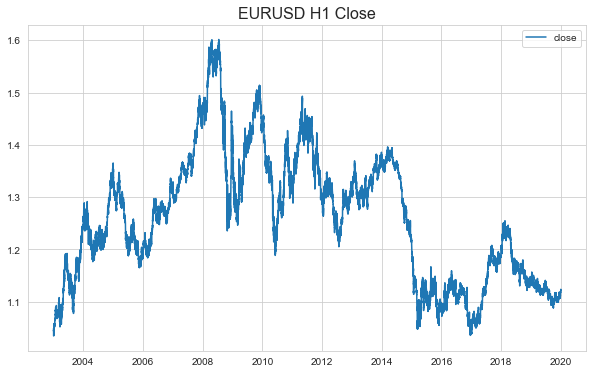

In [4]:
plt.figure(figsize=(10,6))

plt.plot(df_h1['close'], label='close')

plt.title(label = 'EURUSD H1 Close', fontsize=16)
plt.legend()

### Define Target (Label, Resutls) for supervised learning

In [5]:
df_h1.head()

,open,high,low,close
date,,,,
2003-01-01 19:00:00,1.0504,1.0504,1.0476,1.0485
2003-01-01 20:00:00,1.0487,1.0498,1.0485,1.0487
2003-01-01 21:00:00,1.0488,1.0489,1.0477,1.0477
2003-01-01 22:00:00,1.0478,1.0483,1.0468,1.0470
2003-01-01 23:00:00,1.0469,1.0477,1.0469,1.0476


In [6]:
look_ahead_24_all_price_lvl = []

for row in range (len(df_h1.index)):
    row_close = df_h1.iloc[row][3]
    for i in range (1,25):
        try:
            look_ahead_24_all_price_lvl.append(df_h1.iloc[row+i][1] - row_close)
            look_ahead_24_all_price_lvl.append(df_h1.iloc[row+i][2] - row_close)
            look_ahead_24_all_price_lvl.append(df_h1.iloc[row+i][3] - row_close)
        except:
            pass

In [7]:
len(look_ahead_24_all_price_lvl)

7604532

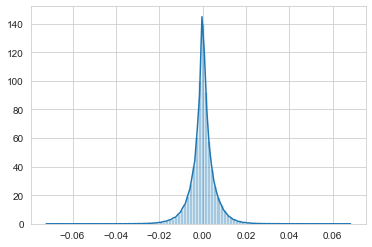

In [8]:
sns.distplot(look_ahead_24_all_price_lvl, bins=100, kde=True)

In [9]:
print(f"Mean: {round(np.mean(look_ahead_24_all_price_lvl),5)}")
print(f"sigma: {round(np.std(look_ahead_24_all_price_lvl),5)}")

Mean: 2e-05
sigma: 0.00553


In [10]:
look_ahead_24 = {}

for row in range (len(df_h1.index)):
    row_close = df_h1.iloc[row][3]
    
    price_samp_24_hi = []
    price_samp_24_lo = []
    for i in range (1,25):
        try:
            price_samp_24_hi.append(df_h1.iloc[row+i][1] - row_close)
            price_samp_24_lo.append(df_h1.iloc[row+i][2] - row_close)
        except:
            pass
    
    try:
        look_ahead_24[df_h1.iloc[row].name] = {}
        look_ahead_24[df_h1.iloc[row].name]['price_list_hi'] = price_samp_24_hi
        look_ahead_24[df_h1.iloc[row].name]['price_list_lo'] = price_samp_24_lo
    except:
            pass    

In [13]:
del_index=[]

for date in look_ahead_24:
    if len(look_ahead_24[date]['price_list_hi']) != 24:
        del_index.append(date)
        print(date, len(look_ahead_24[date]['price_list_hi']))
        print(date, len(look_ahead_24[date]['price_list_lo']))


In [12]:
for date in del_index:
    del look_ahead_24[date]

# 3 Classes

In [14]:
threshold = 0.0050

for date in look_ahead_24:
    for i in range (24):
        if look_ahead_24[date]['price_list_lo'][i] > -0.33*threshold and look_ahead_24[date]['price_list_hi'][i] > threshold:
            look_ahead_24[date]['results'] = 1
            break
        elif look_ahead_24[date]['price_list_hi'][i] < 0.33*threshold and look_ahead_24[date]['price_list_lo'][i] < -1*threshold:
            look_ahead_24[date]['results'] = 2
            break
        else:
            look_ahead_24[date]['results'] = 0

In [15]:
results = pd.DataFrame(look_ahead_24)
results = results.T
results.drop(['price_list_hi', 'price_list_lo'], axis=1, inplace=True)

In [16]:
results.head()

,results
2003-01-01 19:00:00,2
2003-01-01 20:00:00,2
2003-01-01 21:00:00,2
2003-01-01 22:00:00,2
2003-01-01 23:00:00,2


In [17]:
results['results'].value_counts(normalize=True)

1    0.379075
2    0.365345
0    0.255580
Name: results, dtype: float64

In [18]:
df_h1.shape

(105631, 4)

In [19]:
results.shape

(105607, 1)

In [20]:
df_h1_merge = pd.concat([df_h1, results], axis=1)
df_h1_merge.dropna(inplace=True)

In [21]:
df_h1_merge.head()

,open,high,low,close,results
2003-01-01 19:00:00,1.0504,1.0504,1.0476,1.0485,2
2003-01-01 20:00:00,1.0487,1.0498,1.0485,1.0487,2
2003-01-01 21:00:00,1.0488,1.0489,1.0477,1.0477,2
2003-01-01 22:00:00,1.0478,1.0483,1.0468,1.0470,2
2003-01-01 23:00:00,1.0469,1.0477,1.0469,1.0476,2


In [22]:
df_h1_merge.tail()

,open,high,low,close,results
2019-12-30 12:00:00,1.12162,1.12167,1.12088,1.12105,0
2019-12-30 13:00:00,1.12105,1.12121,1.12019,1.12029,0
2019-12-30 14:00:00,1.12032,1.12045,1.11999,1.12021,0
2019-12-30 15:00:00,1.12020,1.12035,1.11963,1.11983,0
2019-12-30 16:00:00,1.11983,1.12027,1.11978,1.11985,0


In [23]:
df_h1_merge.shape

(105607, 5)

In [24]:
df_h1_merge.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105607 entries, 2003-01-01 19:00:00 to 2019-12-30 16:00:00
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   open     105607 non-null  float64
 1   high     105607 non-null  float64
 2   low      105607 non-null  float64
 3   close    105607 non-null  float64
 4   results  105607 non-null  object 
dtypes: float64(4), object(1)
memory usage: 4.8+ MB


In [25]:
df_h1_merge.to_csv('../data/df_h1_merge.csv', index=True)